In [1]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import itertools
import scipy
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

from produce_dataset import *

In [2]:
ntuple_dir = '/ecoderemdvol/EleGun/EPGun-PU200/data/econ_ntuples/0001/'
root_dir = 'FloatingpointAutoEncoderEMDAEMSEttbarDummyHistomaxGenmatchGenclustersntuple'

df_econ = loadEconData(ntuple_dir,root_dir,'econ_data.csv',False)

df_gen = loadGenData(ntuple_dir,root_dir,'gen_data.csv')

In [3]:
df_econ_front_endcap = df_econ[df_econ.zside > 0]

In [4]:
df_econ

,ECON_0,ECON_1,ECON_2,ECON_3,ECON_4,ECON_5,ECON_6,ECON_7,ECON_8,ECON_9,...,ECON_14,ECON_15,subdet,zside,layer,waferu,waferv,wafer_energy,tc_eta,tc_phi
0,0,128,0,128,128,0,128,128,192,64,...,64,128,2,-1,50,7,6,0.0,2.380200,2.320103
1,0,256,128,128,128,0,128,256,0,64,...,128,64,2,-1,50,7,3,0.0,2.351344,2.769872
2,0,192,64,384,192,0,0,0,128,128,...,64,0,2,-1,50,5,6,0.0,2.457676,1.943935
3,0,192,0,64,128,0,64,192,192,128,...,64,64,2,-1,50,5,3,0.0,2.772795,2.640008
4,0,256,128,128,128,0,128,256,0,64,...,128,64,2,1,50,5,3,0.0,2.772795,2.640008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13151,0,128,64,64,64,0,128,64,64,128,...,192,320,2,1,50,2,6,0.0,2.563872,1.379396
13152,0,192,256,64,64,0,64,192,192,64,...,64,64,2,1,50,3,-1,0.0,2.820167,-2.757138
13153,0,320,64,64,320,0,64,64,256,256,...,128,128,2,1,50,4,5,0.0,2.754663,1.986027
13154,0,256,320,64,64,0,64,256,256,0,...,0,64,2,1,50,6,2,0.0,2.522794,2.994740


In [5]:
df_nodes=df_econ_front_endcap[['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
       'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15', 
        'wafer_energy', 'tc_eta', 'tc_phi']]
df_nodes.reset_index(inplace=True)
df_nodes

,index,ECON_0,ECON_1,ECON_2,ECON_3,ECON_4,ECON_5,ECON_6,ECON_7,ECON_8,ECON_9,ECON_10,ECON_11,ECON_12,ECON_13,ECON_14,ECON_15,wafer_energy,tc_eta,tc_phi
0,4,0,256,128,128,128,0,128,256,0,64,0,192,64,128,128,64,0.0,2.772795,2.640008
1,9,0,128,320,64,128,0,128,64,128,64,64,192,192,64,192,64,0.0,2.906582,2.157504
2,11,0,256,384,0,64,0,0,128,64,64,64,64,384,64,0,64,0.0,2.931900,2.454957
3,13,0,128,192,64,128,0,128,128,128,128,128,128,192,64,128,64,0.0,2.948522,2.773153
4,15,0,0,64,64,192,0,64,192,128,192,192,128,192,64,192,192,0.0,2.880833,2.642526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6542,13151,0,128,64,64,64,0,128,64,64,128,0,64,0,0,192,320,0.0,2.563872,1.379396
6543,13152,0,192,256,64,64,0,64,192,192,64,64,64,192,64,64,64,0.0,2.820167,-2.757138
6544,13153,0,320,64,64,320,0,64,64,256,256,192,320,64,64,128,128,0.0,2.754663,1.986027
6545,13154,0,256,320,64,64,0,64,256,256,0,64,64,192,0,0,64,0.0,2.522794,2.994740


In [6]:
#only choose wafers in some range now
#know electron is ~ -pi/2 and choose 30 degree range around it 1.31 to 1.93

df_econ_front_endcap_30deg = df_econ_front_endcap[df_econ_front_endcap.tc_phi > -1.93]
df_econ_front_endcap_30deg = df_econ_front_endcap_30deg[df_econ_front_endcap_30deg.tc_phi < -1.31]

In [7]:
df_econ_front_endcap_30deg

,ECON_0,ECON_1,ECON_2,ECON_3,ECON_4,ECON_5,ECON_6,ECON_7,ECON_8,ECON_9,...,ECON_14,ECON_15,subdet,zside,layer,waferu,waferv,wafer_energy,tc_eta,tc_phi
43,0,192,128,128,192,0,64,64,192,192,...,64,64,2,1,50,-2,-3,0.0,2.919332,-1.409119
45,0,0,320,128,64,0,256,0,192,64,...,320,0,2,1,50,-2,-4,0.0,2.759997,-1.487732
98,0,128,128,64,128,0,192,64,192,64,...,64,64,2,1,49,-2,-5,0.0,2.803752,-1.709183
111,0,192,64,64,192,0,64,64,192,192,...,128,64,2,1,49,-4,-6,0.0,2.548851,-1.376413
156,0,128,128,128,192,0,128,128,128,64,...,0,128,2,1,48,-1,-3,0.0,2.914386,-1.719316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13109,0,64,128,192,64,0,128,64,64,128,...,128,128,2,1,47,-3,-6,0.0,2.532565,-1.523919
13112,0,128,64,64,64,0,64,64,128,128,...,64,128,2,1,47,-1,-5,0.0,2.697717,-1.884058
13113,0,64,64,64,192,0,128,128,64,64,...,64,128,2,1,47,-1,-4,0.0,2.910776,-1.871482
13130,0,192,64,64,256,0,64,0,192,128,...,128,64,2,1,49,-3,-5,0.0,2.796680,-1.400798


In [8]:
count = (df_econ_front_endcap_30deg['wafer_energy'] != 0).sum()
print(count)

70


In [9]:
df_econ_front_endcap_30deg.reset_index(inplace=True)
df_nodes=df_econ_front_endcap_30deg
embeddings = torch.tensor(df_nodes.values)

In [10]:
eta=df_nodes['tc_eta']
phi=df_nodes['tc_phi']
idx = range(len(eta))
indices_i = np.array([i for i,j in itertools.product(idx,idx)])
indices_j = np.array([j for i,j in itertools.product(idx,idx)])

In [11]:
del_R = np.empty([len(eta),len(eta)])
del_R.shape

(666, 666)

In [12]:
for (i, j) in zip(indices_i,indices_j):
    del_R[i][j]=np.sqrt((eta[i]-eta[j])**2+((phi[i]-phi[j])%(2*np.pi))**2)

In [13]:
del_R = torch.tensor(del_R)

In [14]:
del_R

tensor([[0.0000, 0.1777, 0.3216,  ..., 0.4624, 6.2761, 0.4191],
        [6.2066, 0.0000, 0.2257,  ..., 0.4123, 6.1964, 0.3067],
        [5.9842, 6.0619, 0.0000,  ..., 0.1944, 5.9748, 0.0984],
        ...,
        [5.8208, 5.9014, 6.1218,  ..., 0.0000, 5.8136, 6.2081],
        [0.1229, 0.0944, 0.3085,  ..., 0.4843, 0.0000, 0.3958],
        [5.9002, 5.9765, 6.1982,  ..., 0.1743, 5.8897, 0.0000]],
       dtype=torch.float64)

In [15]:
adj = np.zeros([len(eta),len(eta)])
for (i, j) in zip(indices_i,indices_j):
    if del_R[i][j] <0.045 and  del_R[i][j]> 0 :
        adj[i][j]=1
adj=torch.tensor(adj)       

In [16]:
edge_index = (adj > 0).nonzero().t()
edge_index.shape

torch.Size([2, 2497])

In [17]:
ys = torch.tensor(df_nodes['wafer_energy'])

In [18]:
graph = data.Data(x=embeddings, edge_index=edge_index, y=ys)

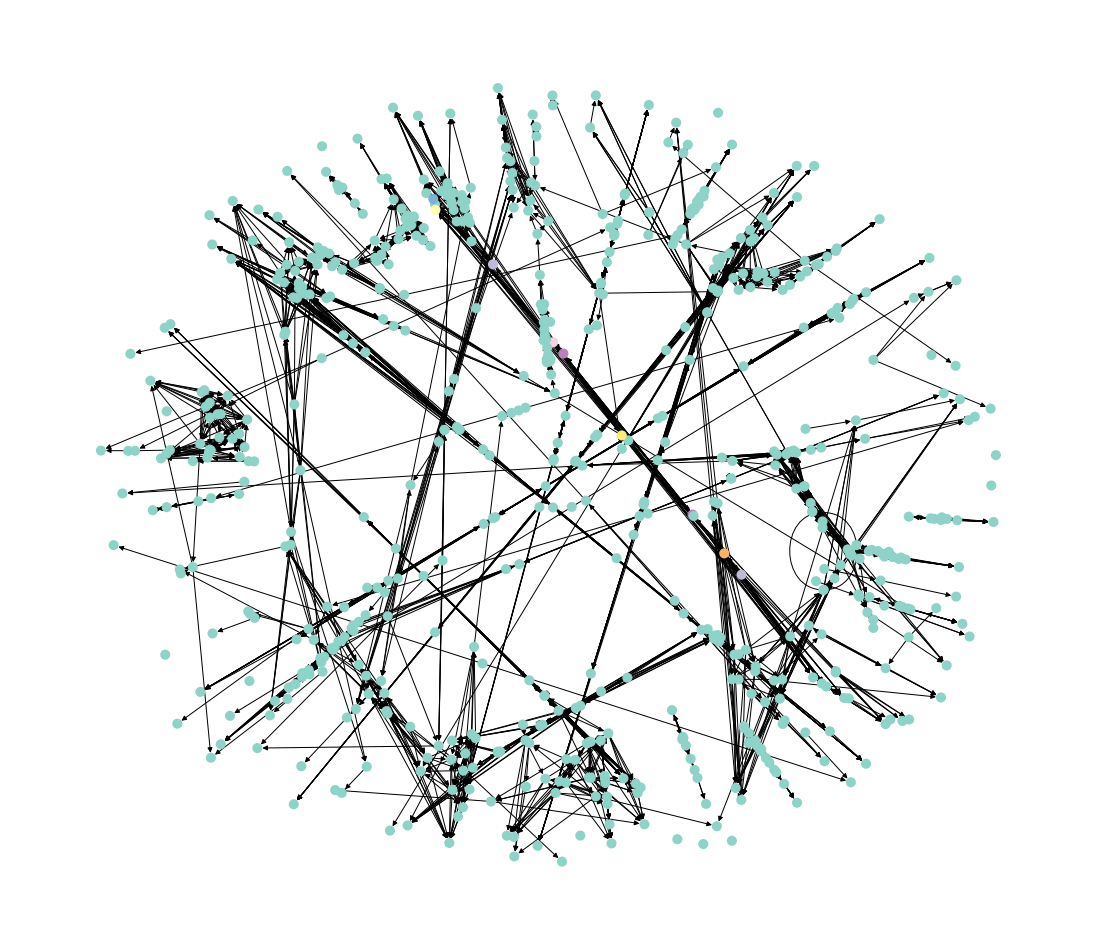

In [19]:
vis = to_networkx(graph)
#color per wafer_energy, could also make this sum of econ_charges
node_labels = graph.y.numpy()
plt.figure(1,figsize=(15,13)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color =node_labels,node_size=100,linewidths=0.05)
plt.show()

In [20]:
cols = ['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
       'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15']

#find sum of columns specified 
df_nodes['sum'] = df_nodes[cols].sum(axis=1)

In [21]:
df_nodes.reset_index(drop=True,inplace=True)

In [22]:
df_nodes

,index,ECON_0,ECON_1,ECON_2,ECON_3,ECON_4,ECON_5,ECON_6,ECON_7,ECON_8,...,ECON_15,subdet,zside,layer,waferu,waferv,wafer_energy,tc_eta,tc_phi,sum
0,43,0,192,128,128,192,0,64,64,192,...,64,2,1,50,-2,-3,0.0,2.919332,-1.409119,1728
1,45,0,0,320,128,64,0,256,0,192,...,0,2,1,50,-2,-4,0.0,2.759997,-1.487732,1792
2,98,0,128,128,64,128,0,192,64,192,...,64,2,1,49,-2,-5,0.0,2.803752,-1.709183,1600
3,111,0,192,64,64,192,0,64,64,192,...,64,2,1,49,-4,-6,0.0,2.548851,-1.376413,2048
4,156,0,128,128,128,192,0,128,128,128,...,128,2,1,48,-1,-3,0.0,2.914386,-1.719316,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,13109,0,64,128,192,64,0,128,64,64,...,128,2,1,47,-3,-6,0.0,2.532565,-1.523919,1728
662,13112,0,128,64,64,64,0,64,64,128,...,128,2,1,47,-1,-5,0.0,2.697717,-1.884058,1600
663,13113,0,64,64,64,192,0,128,128,64,...,128,2,1,47,-1,-4,0.0,2.910776,-1.871482,1472
664,13130,0,192,64,64,256,0,64,0,192,...,64,2,1,49,-3,-5,0.0,2.796680,-1.400798,1856


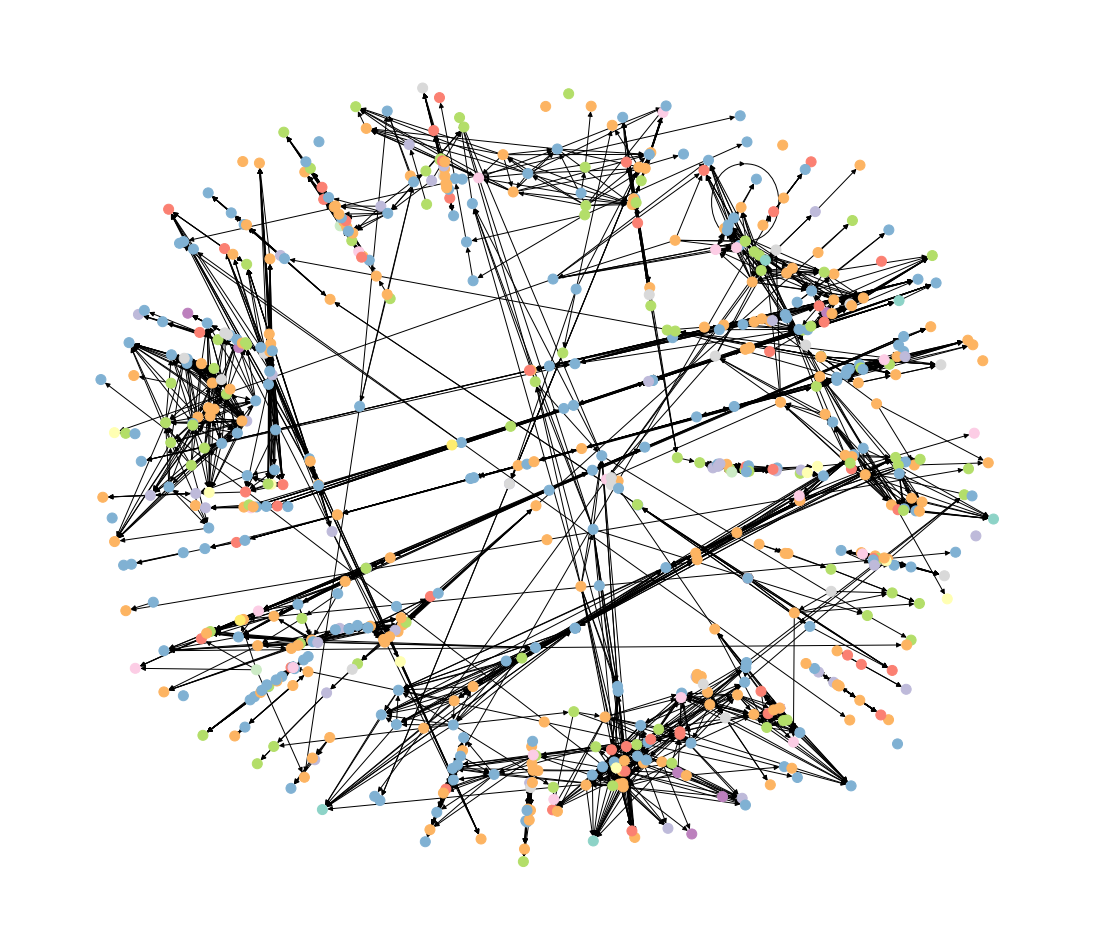

In [23]:
ys = torch.tensor(df_nodes['sum'])
graph = data.Data(x=embeddings, edge_index=edge_index, y=ys)
vis = to_networkx(graph)
#color sum of econ_charges
node_labels = graph.y.numpy()
plt.figure(1,figsize=(15,13)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color =node_labels,node_size=100,linewidths=1)
plt.show()

In [24]:
from scipy import stats


<ErrorbarContainer object of 3 artists>

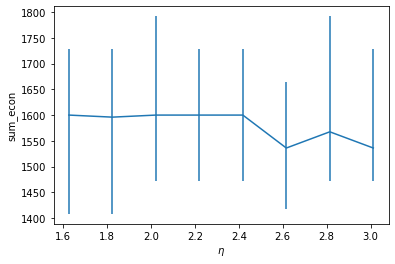

In [25]:
x=df_nodes['tc_eta']
y=df_nodes['sum']
        
nbins=8
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.ylabel('sum_econ')
plt.xlabel(r'$\eta$')
plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie])


<ErrorbarContainer object of 3 artists>

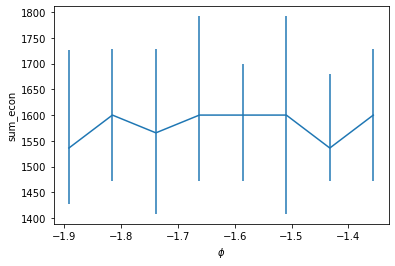

In [26]:
x=df_nodes['tc_phi']
y=df_nodes['sum']
        
nbins=8
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.ylabel('sum_econ')
plt.xlabel(r'$\phi$')
plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie])

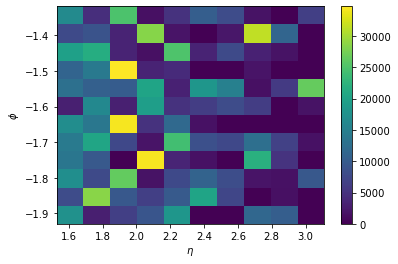

In [27]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
h = ax.hist2d(x=eta,y=phi,bins=(10,12),weights=df_nodes['sum'])
fig.colorbar(h[3], ax=ax)
plt.xlabel(r'$\eta$');
plt.ylabel(r'$\phi$');

electron was shot from eta: 2.56, phi: 	-1.5370439

